## Conditional GAN Implementation

Based on the paper: <i>Conditional Generative Adversarial Nets</i> and <i>Least Squares Generative Adversarial Networks</i>. There is a good guide [here](https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/).

In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input,Dense,Reshape,Dropout,BatchNormalization,Activation,UpSampling2D,Embedding
from tensorflow.keras.layers import BatchNormalization,Conv2D,LeakyReLU,Flatten,Conv2DTranspose,Concatenate
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.losses import BinaryCrossentropy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
tf.keras.backend.set_floatx('float32')

import warnings
warnings.filterwarnings('ignore')

### Data Cleaning

In [2]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')
x_train = x_train[y_train <= 3] # using numbers 0,1,2,3
y_train = y_train[y_train <= 3]
y_train = y_train.astype("int32")
y_train = np.expand_dims(y_train,axis=-1)
#one_hot_y = np.zeros((len(y_train),4)) # getting one_hot encoding for labels
#one_hot_y[np.arange(y_train.size),y_train]=1
x_train = np.expand_dims(x_train,axis=-1)
x_train = x_train[:24750]
y_train = y_train[:24750]
print(x_train.shape,y_train.shape)

(24750, 28, 28, 1) (24750, 1)


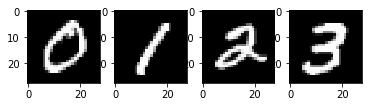

In [3]:
plt.subplot(1,4,1)
plt.imshow(np.squeeze(x_train[0]),cmap="gray")
plt.subplot(1,4,2)
plt.imshow(np.squeeze(x_train[1]),cmap="gray")
plt.subplot(1,4,3)
plt.imshow(np.squeeze(x_train[2]),cmap="gray")
plt.subplot(1,4,4)
plt.imshow(np.squeeze(x_train[4]),cmap="gray")
plt.show()

In [4]:
x_train = x_train/255 # scaling the images

### Model Implementation

In [6]:
def get_generator(noise_dim=100,class_dim=4):
    """ conditional generator implementation
        -class representation is added as an "extra" channel to the base of the generated image
    """
    z = Input(shape=(noise_dim))
    label = Input(shape=(1))
    label_h = Embedding(input_dim=class_dim,output_dim=100)(label)
    label_h = Dense(7*7)(label_h)
    label_h = Reshape((7,7,1))(label_h)
    
    h = Dense(7*7*256)(z)
    h = BatchNormalization(momentum=0.9)(h)
    h = Activation('relu')(h)
    h = Reshape((7,7,256))(h)
    h = Concatenate()([h,label_h]) # adding the class-representation as an extra channel
    h = Dropout(0.4)(h)
    
    h = Conv2DTranspose(filters=128,kernel_size=5,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.9)(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.9)(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters=32,kernel_size=5,strides=1,padding='same',activation=None)(h)
    h = BatchNormalization(momentum=0.9)(h)
    h = Activation('relu')(h)
    h = Conv2DTranspose(filters=1,kernel_size=5,strides=1,padding='same',activation=None)(h)
    h = Activation('sigmoid')(h)
    
    model = Model(inputs=[z,label],outputs=h)
    return model

In [7]:
def get_discriminator(class_dim=4):
    """ conditional discriminator implementation
        -class representation is added as an "extra" channel to the input image
    """
    x = Input(shape=(28,28,1))
    label = Input(shape=(1))
    label_h = Embedding(input_dim=class_dim,output_dim=100)(label)
    label_h = Dense(28*28)(label_h)
    label_h = Reshape((28,28,1))(label_h)
    
    h = Concatenate()([x,label_h]) # adding the class-representation as an extra channel
    h = Conv2D(filters=64,kernel_size=5,strides=2,padding='same',activation=None)(h)
    h = LeakyReLU(0.2)(h)
    h = Dropout(0.4)(h)
    h = Conv2D(filters=128,kernel_size=5,strides=2,padding='same',activation=None)(h)
    h = LeakyReLU(0.2)(h)
    h = Dropout(0.4)(h)
    h = Conv2D(filters=256,kernel_size=5,strides=2,padding='same',activation=None)(h)
    h = LeakyReLU(0.2)(h)
    h = Dropout(0.4)(h)
    h = Flatten()(h)
    h = Dense(1,activation=None)(h)
    
    model = Model(inputs=[x,label],outputs=h)
    return model

In [8]:
def discriminator_model(discriminator,optimizer=Adam(lr=0.0002)):
    """ compiling discriminator model
    """
    x = Input(shape=(28,28,1))
    label = Input(shape=(1))
    out = discriminator([x,label])
    
    model = Model(inputs=[x,label],outputs=out)
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

In [9]:
def adversarial_model(generator,discriminator,noise_dim=100,optimizer=Adam(lr=0.0001)):
    """ compiling adversarial model - used to train generator
    """
    z = Input(shape=(noise_dim))
    label = Input(shape=(1))
    gen = generator([z,label])
    out = discriminator([gen,label])
    
    model = Model(inputs=[z,label],outputs=out)
    model.compile(loss='mean_squared_error',optimizer=optimizer)
    return model

### Model Training

The noise prior z~N(0,1)

In [10]:
d = get_discriminator()
generator = get_generator()
discriminator = discriminator_model(d)
adversarial = adversarial_model(generator,d)

In [11]:
num_epochs=30
batch_size=50

for epoch_i in range(num_epochs): # number of epochs
    all_a_losses = []
    all_d_losses = []
    print("Epoch {}:".format(epoch_i+1))
    
    for i in range(0,len(x_train)-batch_size,batch_size): # looping through batches rather than sampling
        x_subset = x_train[i:i+batch_size]
        y_subset = y_train[i:i+batch_size]
        
        # training the discriminator:
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        x_gen = generator([z,y_subset])
        x = np.concatenate((x_subset,x_gen))
        y = np.vstack([np.ones((batch_size,1)),np.zeros((batch_size,1))])
        discriminator.trainable=True
        d_loss = discriminator.train_on_batch([x,np.vstack([y_subset,y_subset])],y)
        all_d_losses.append(float(d_loss))
        
        # training the generator:
        y = np.ones([batch_size,1]) # we switch the labels here to maximize the domain-confusion
        z = np.random.normal(0.0,1.0,size=(batch_size,100))
        discriminator.trainable=False # prevents discriminator from being updated when it should only be the generator
        a_loss = adversarial.train_on_batch([z,y_subset],y)
        all_a_losses.append(float(a_loss))
        
        if i%2000 == 0:
            for _ in range(4): # making 4 plots
                this_noise = np.random.normal(0.0,1.0,size=(1,100))
                for i in range(4):
                    this_label = np.array([[i]])
                    gen = generator([this_noise,this_label])
                    gen = gen.numpy()*255
                    gen.shape=(28,28)
                    plt.subplot(1,4,i+1)
                    plt.imshow(gen,cmap="gray")
                plt.show()
            
    print("gen. loss:{}; disc. loss:{}".format(sum(all_a_losses)/len(all_a_losses),sum(all_d_losses)/len(all_d_losses)))            
    print("--------------------------------------------------------------------------------------------------")

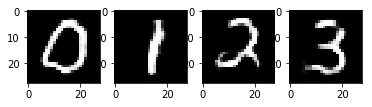

In [22]:
this_noise = np.random.normal(0.0,1.0,size=(1,100))
for i in range(4):
    this_label = np.array([[i]])
    gen = generator([this_noise,this_label])
    gen = gen.numpy()*255
    gen.shape=(28,28)
    plt.subplot(1,4,i+1)
    plt.imshow(gen,cmap="gray")
plt.show()

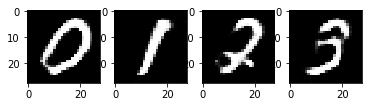

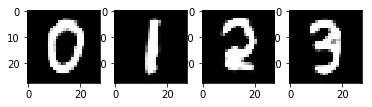

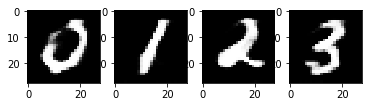

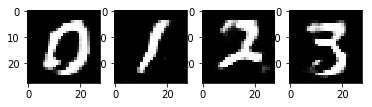

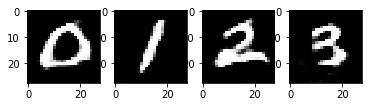